# Project: modelling a thermal building

Intro: What we are modelling and how

In this simple example we are modelling a simple wall

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

#insert image

![wall](walldrawing.jpeg)

Now we must insert the properties of the wall and of air

In [2]:
# Physical properties of the wall and of air
# ===================
wall = {'Conductivity': [1.400],
        'Density': [2300.0],
        'Specific heat': [880],
        'Width': [0.2],
        'Meshes': [4]}
wall = pd.DataFrame(wall, index=['Concrete'])
wall

,Conductivity,Density,Specific heat,Width,Meshes
Concrete,1.4,2300.0,880,0.2,4


In [3]:
air = {'Density': 1.2,
       'Specific heat': 1000}

pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


More required inputs are convection coefficiens

In [4]:
# convection coefficients, W/(m²·K)
h = pd.DataFrame([{'in': 4., 'out': 10.}], index=['h'])
h

,in,out
h,4.0,10.0


Then we need the dimensions of the wall

In [5]:
S_wall = 3 * 3      # m², wall surface area
V_air = 3 * 3 * 3   # m³, indoor air volume

Now we can calculate the thermal conduction based on the dimensons of the wall

In [6]:
# conduction, convection (resistances)
R_cd = wall['Width'] / (wall['Conductivity'] * S_wall)  # K/W
R_cv = 1 / (h * S_wall)     # K/W

Now the thermal capacity of the wall

In [7]:
C_wall = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall

We can start with the matrices

A - incidence matrix

G - Conductance matrix

C - Capacity matrix

In [8]:
A = np.zeros([3,3])
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
pd.DataFrame(A)

,0,1,2
0,1.0,0.0,0.0
1,-1.0,1.0,0.0
2,0.0,-1.0,1.0


In [9]:
G = np.diag([1,2,2])
pd.DataFrame(G)

,0,1,2
0,1,0,0
1,0,2,0
2,0,0,2


In [10]:
C = np.diag([0,5,0])
pd.DataFrame(C)

,0,1,2
0,0,0,0
1,0,5,0
2,0,0,0


The sources are only one: temperature source

In [11]:
b = np.zeros(3)
b[0]=20
f = np.zeros(3)
y = np.zeros(3)
y[-1] = 1
print(b)
print(y)

[20.  0.  0.]
[0. 0. 1.]


We can solve the steady state modl to see that there is nothing wrong

In [12]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b)
print(θ)

[20. 20. 20.]


Now that the steady state model is not wrong, we can go fot the dynamic model, using state space equations

In [13]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-0.13333333]] 

Bs = 
 [[0.13333333]] 

Cs = 
 [[1.]] 

Ds = 
 [[0.]] 



To be sure the model is correct, I must check that the steady state of the state space representation is the same as the algeb

In [14]:
bT = np.array([20,0,0])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0])         # [Φo, Φi, Qa, Φa]
u = np.array([20])
print(f'u = {u}')
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u.T
print(f'yss = {yss} °C')

u = [20]
yss = [20.] °C


In [15]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[2] - yss)):.2e} °C')

Max error between DAE and state-space: 7.11e-15 °C


The error is accpetable

## Now the time step

In [16]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = min(-2. / λ)
print(f'Maximum time step: {dtmax:.2f} s ')

Time constants: 
 [7.5] s 

2 x Time constants: 
 [15.] s 

Maximum time step: 15.00 s 


In [17]:
dt = 1     # seconds
print(f'dt = {dt} s')

dt = 1 s


Then once the time step is defined, we can define the settling time

In [18]:
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s')

Time constants: 
 [7.5] s 

Settling time: 30 s


## Now that I have the time step, we can calculate the dynamic response of a system

In [19]:
duration =  60       # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

Duration = 60 s
Number of time steps = 60


,time
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [20]:
u = np.zeros([1, n])                # u = [non-zero temp sources]
u[0:1, :] = 20 * np.ones([1, n])    # To = 10 for all time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0


## Time integration

In [21]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

In [22]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

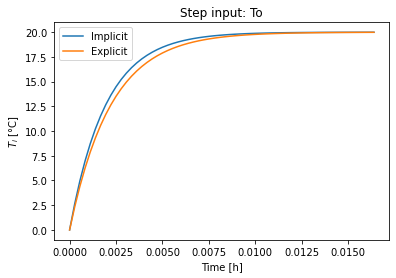

In [23]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax.legend(['Implicit', 'Explicit'])
plt.show()

## Simulation with weather data

In [24]:
filename = './weather_data/CHE_VD_Nyon.Changins.067050_TMYx.2004-2018.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

We want to reduce the data to a few days

In [25]:
start_date = '2000-05-05 12:00:00'
end_date = '2000-05-08 18:00:00'

print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-05-05 12:00:00 	start date
2000-05-08 18:00:00 	end date


In [26]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]

pd.DataFrame(weather)

,temp_air,dir_n_rad,dif_h_rad
2000-05-05 12:00:00+01:00,19.4,828,158
2000-05-05 13:00:00+01:00,20.0,844,146
2000-05-05 14:00:00+01:00,20.4,829,132
2000-05-05 15:00:00+01:00,20.5,755,137
2000-05-05 16:00:00+01:00,20.7,618,144
...,...,...,...
2000-05-08 13:00:00+01:00,17.0,773,215
2000-05-08 14:00:00+01:00,17.6,767,186
2000-05-08 15:00:00+01:00,17.9,746,149
2000-05-08 16:00:00+01:00,17.5,615,150


### quick check the temperature on a graph

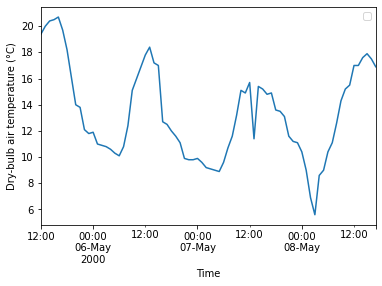

In [27]:
weather[['temp_air']].plot()
plt.xlabel("Time")
plt.ylabel("Dry-bulb air temperature (°C)")
plt.legend([])
plt.show()

The outdoor temperature is samples every hour. we have a 1second time step. We need to re-sample

In [28]:
#number of steps in our simulation, one step is 
print('One step in our simulation is', dt , 's')
hours = weather.shape[0]
print('the total number of hours we have in our simulation is :', hours)
# number of steps
print('if every', dt ,'seconds we have a step, then for the 78 hours we have:')
n = (int(hours*3600) / dt)
print('We have a total of', n, 'steps')

One step in our simulation is 1 s
the total number of hours we have in our simulation is : 78
if every 1 seconds we have a step, then for the 78 hours we have:
We have a total of 280800.0 steps


We have the total number of steps in our time interval, now we can produce the temperature vector

In [29]:
t = np.arange(0,  3600 * weather.shape[0], dt)
tw = np.arange(0,  3600 * weather.shape[0], 3600)
θ_out = np.interp(t, tw, weather['temp_air'])
pd.DataFrame(t, columns=['time'])
pd.DataFrame(θ_out, index=t, columns=['θ °C'])

,θ °C
0,19.400000
1,19.400167
2,19.400333
3,19.400500
4,19.400667
...,...
280795,16.900000
280796,16.900000
280797,16.900000
280798,16.900000


In [30]:
u = np.block([[θ_out]])
pd.DataFrame(u, index=['To'])

,0,1,2,3,4,5,6,7,8,9,...,280790,280791,280792,280793,280794,280795,280796,280797,280798,280799
To,19.4,19.400167,19.400333,19.4005,19.400667,19.400833,19.401,19.401167,19.401333,19.4015,...,16.9,16.9,16.9,16.9,16.9,16.9,16.9,16.9,16.9,16.9


## Time integration

In [31]:
θ_exp = np.zeros([1, t.shape[0]])
θ_imp = np.zeros([1, t.shape[0]])

print(θ_imp.shape)

(1, 280800)


In [32]:
for k in range(u.shape[1] - 1):
    θ_exp[:, k + 1] = (np.eye(1) + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(np.eye(1) - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])


In [33]:
print(u)

[[19.4        19.40016667 19.40033333 ... 16.9        16.9
  16.9       ]]


In [39]:
pd.DataFrame(θ_imp)

,0,1,2,3,4,5,6,7,8,9,...,280790,280791,280792,280793,280794,280795,280796,280797,280798,280799
0,0.0,2.282353,4.296213,6.073169,7.64109,9.02457,10.245307,11.322447,12.272885,13.111526,...,16.9,16.9,16.9,16.9,16.9,16.9,16.9,16.9,16.9,16.9


In [35]:
print(θ_exp)
print(θ_exp[-1,:])


[[ 0.          2.58666667  4.82846667 ... 16.9        16.9
  16.9       ]]
[ 0.          2.58666667  4.82846667 ... 16.9        16.9
 16.9       ]


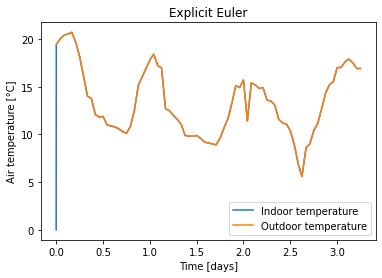

In [36]:
fig, ax = plt.subplots()
ax.plot(t / 3600 / 24, θ_exp[-1, :], label='Indoor temperature')
ax.plot(t / 3600 / 24, θ_out, label='Outdoor temperature')
ax.set(xlabel='Time [days]',
       ylabel='Air temperature [°C]',
       title='Explicit Euler')
ax.legend()
plt.show()

## Conclusion

It looks like it is not working, but actually it is. If we open the scropt in pyhton and soom in, we can see that the **blue line follows perfectly the orange line**. That means that a simple wall like I modeled will not protects us from variations in the outdoor temperature. 

To solve this problem, we need a wall with an insulation, (= bigger accumulation capacity). more layers etc... 
